In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV

# Rede Neural - Regressão Simples

In [3]:
# Importando base de dados
base = pd.read_csv('../dados/autos.csv', encoding = 'ISO-8859-1')
base.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# Excluindo features
base = base.drop(['dateCrawled', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen', 'name', 'seller', 'offerType'], axis = 1)

In [5]:
base.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


## Saneamento dos dados
### Tratando valores nulos

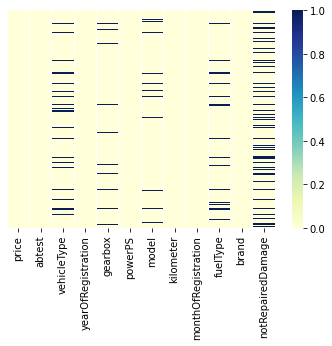

In [8]:
# Verificando valores nulos
sb.heatmap(base.isnull(), cmap = "YlGnBu", yticklabels = False)

In [6]:
base.isnull().sum().sort_values(ascending = False)

notRepairedDamage      72060
vehicleType            37869
fuelType               33386
model                  20484
gearbox                20209
price                      0
abtest                     0
yearOfRegistration         0
powerPS                    0
kilometer                  0
monthOfRegistration        0
brand                      0
dtype: int64

In [ ]:
# Verificando icidências de valores nullos nas features
print(base['notRepairedDamage'].value_counts())
print()
print(base['vehicleType'].value_counts())
print()
print(base['fuelType'].value_counts())
print()
print(base['model'].value_counts())  
print()
print(base['gearbox'].value_counts()) 

nein    263182
ja       36286
Name: notRepairedDamage, dtype: int64

limousine     95894
kleinwagen    80023
kombi         67564
bus           30201
cabrio        22898
coupe         19015
suv           14707
andere         3357
Name: vehicleType, dtype: int64

benzin     223857
diesel     107746
lpg          5378
cng           571
hybrid        278
andere        208
elektro       104
Name: fuelType, dtype: int64

golf               30070
andere             26400
3er                20567
polo               13092
corsa              12573
                   ...  
serie_2                8
rangerover             6
serie_3                4
serie_1                2
discovery_sport        1
Name: model, Length: 251, dtype: int64

manuell      274214
automatik     77105
Name: gearbox, dtype: int64


In [7]:
# Substistuindo valores nulos, pelos valores que mais aparecem 
valores = {
    'notRepairedDamage': 'nein',
    'vehicleType': 'limousine', 
    'fuelType': 'benzin',
    'model': 'golf', 
    'gearbox': 'manuell'
}

base = base.fillna(value = valores)

In [8]:
base.isnull().sum().sort_values(ascending = False)

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

In [9]:
# Retirando registros com valores discrepantes
base = base[base.price > 10]
base = base.loc[base.price < 350000]

In [10]:
# Separando features e target
previsores = base.iloc[:, 1:13]
preco_real = base.iloc[:, 0]

In [11]:
previsores.head()

,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,test,limousine,1993,manuell,0,golf,150000,0,benzin,volkswagen,nein
1,test,coupe,2011,manuell,190,golf,125000,5,diesel,audi,ja
2,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,nein
3,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


### LabelEncoder

In [ ]:
# Tranformando as features odjects para númericas
le = LabelEncoder()
for column_name in previsores.columns:
    if previsores[column_name].dtype == object:
        print('Applay LabelEncoder Column: ' + column_name)
        previsores[column_name] = le.fit_transform(previsores[column_name])
    else:
        pass

In [ ]:
previsores.head()

### OneHotEncoder

In [12]:
# Tranformando as features odjects para númericas, usando get_dummies
previsores = pd.get_dummies(data = previsores, columns = ['abtest', 'vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage'])

In [16]:
previsores.head()

,yearOfRegistration,powerPS,kilometer,monthOfRegistration,abtest_control,abtest_test,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,vehicleType_kombi,vehicleType_limousine,vehicleType_suv,gearbox_automatik,gearbox_manuell,model_100,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,...,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notRepairedDamage_ja,notRepairedDamage_nein
0,1993,0,150000,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,2011,190,125000,5,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2004,163,125000,8,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2001,75,150000,6,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,2008,69,90000,7,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [13]:
# Estrutura da rede neural
regressor = Sequential()
regressor.add(Dense(units = 158, activation = 'relu', input_dim = 316))
regressor.add(Dense(units = 158, activation = 'relu'))
regressor.add(Dense(units = 1, activation = 'linear'))
# Compilando rede neural
regressor.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['mean_absolute_error'])
# Treinando rede neural
regressor.fit(previsores, preco_real, batch_size = 300, epochs = 100)

Epoch 1/100
1198/1198 [==============================] - 5s 4ms/step - loss: 4367.9950 - mean_absolute_error: 4367.9950
Epoch 2/100
1198/1198 [==============================] - 4s 4ms/step - loss: 3457.5762 - mean_absolute_error: 3457.5762
Epoch 3/100
1198/1198 [==============================] - 4s 4ms/step - loss: 3303.8518 - mean_absolute_error: 3303.8518
Epoch 4/100
1198/1198 [==============================] - 5s 4ms/step - loss: 2991.7179 - mean_absolute_error: 2991.7179
Epoch 5/100
1198/1198 [==============================] - 6s 5ms/step - loss: 2843.0813 - mean_absolute_error: 2843.0815
Epoch 6/100
1198/1198 [==============================] - 5s 4ms/step - loss: 2787.5604 - mean_absolute_error: 2787.5604
Epoch 7/100
1198/1198 [==============================] - 5s 4ms/step - loss: 2739.2853 - mean_absolute_error: 2739.2853
Epoch 8/100
1198/1198 [==============================] - 4s 4ms/step - loss: 2681.0532 - mean_absolute_error: 2681.0532
Epoch 9/100
1198/1198 [=================

In [ ]:
previsoes = regressor.predict(previsores)

In [ ]:
preco_real.mean()

5916.833945186492

In [ ]:
previsoes.mean()

5052.8457

# Rede Neural - Regressão Simples
## Validação Cruzada com K-fold 

In [ ]:
# Criando função para rede neural
def criar_rede():
    # Criando estrutura da rede neural
    regressor = Sequential()
    regressor.add(Dense(units = 158, activation = 'relu', input_dim = 316))
    regressor.add(Dense(units = 158, activation = 'relu'))
    regressor.add(Dense(units = 1, activation = 'linear'))
    # Compilando rede neural
    regressor.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['mean_absolute_error'])
    
    return regressor

In [ ]:
# Parâmetros para treinamento, usando KerasClassifier
regressor = KerasRegressor(build_fn = criar_rede, epochs = 100, batch_size = 300)

In [ ]:
# Executando treinamento e teste usando validação cruzada com 5 folds
resultados = cross_val_score(estimator = regressor, X = previsores, y = preco_real, cv = 5, scoring = 'mean_absolute_error')

Epoch 1/100
959/959 [==============================] - 6s 6ms/step - loss: 4288.5810 - mean_absolute_error: 4288.5810
Epoch 2/100
959/959 [==============================] - 5s 5ms/step - loss: 3512.0520 - mean_absolute_error: 3512.0520
Epoch 3/100
959/959 [==============================] - 5s 5ms/step - loss: 3399.2507 - mean_absolute_error: 3399.2507
Epoch 4/100
959/959 [==============================] - 5s 6ms/step - loss: 3235.6779 - mean_absolute_error: 3235.6779
Epoch 5/100
959/959 [==============================] - 5s 5ms/step - loss: 2971.3406 - mean_absolute_error: 2971.3406
Epoch 6/100
959/959 [==============================] - 6s 6ms/step - loss: 2852.0584 - mean_absolute_error: 2852.0584
Epoch 7/100
959/959 [==============================] - 5s 6ms/step - loss: 2771.9864 - mean_absolute_error: 2771.9864
Epoch 8/100
959/959 [==============================] - 5s 5ms/step - loss: 2738.3362 - mean_absolute_error: 2738.3362
Epoch 9/100
959/959 [==============================] - 5

In [ ]:
resultados

array([-2195.37207031, -2404.08789062, -2480.97314453, -2304.84277344,
       -2352.54711914])

In [ ]:
media = resultados.mean()
media

-2347.564599609375

In [ ]:
desvio = resultados.std()
desvio

95.92212277835424

# Rede Neural - Classificação Multiclesse
## Validação Cruzada com K-fold e GridSearchCV

In [14]:
# Criando função para rede neural
def criarRede(loss):
    # Criando estrutura da rede neural
    regressor = Sequential()
    regressor.add(Dense(units = 158, activation = 'relu', kernel_initializer = 'random_uniform', input_dim = 316))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 158, activation = 'relu', kernel_initializer = 'random_uniform'))
    # regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1, activation = 'linear'))
    # Compilando rede neural
    regressor.compile(optimizer = 'adam', loss = loss, metrics = ['mean_absolute_error'])

    return regressor

In [15]:
# Parâmetros para treinamento, usando KerasClassifier
regressor = KerasRegressor(build_fn = criarRede, epochs = 100, batch_size = 300)

# Parâmetros para o GridSearchCV
parametros = {
    'loss': [
        'mean_squared_error', 
        'mean_absolute_error',
        'mean_absolute_percentage_error', 
        'mean_squared_logarithmic_error',
        'squared_hinge'
]}

In [16]:
# Parâmetros para o execução do GridSearchCV
grid_search = GridSearchCV(estimator = regressor, param_grid = parametros, cv = 10)

In [51]:
# Executando treinamento e teste usando GridSearchCV
grid_search = grid_search.fit(previsores, preco_real)

Epoch 1/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1380.7331 - mean_absolute_error: 1380.7331
Epoch 2/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1383.4522 - mean_absolute_error: 1383.4522
Epoch 3/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1386.3433 - mean_absolute_error: 1386.3433
Epoch 4/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1384.9112 - mean_absolute_error: 1384.9112
Epoch 5/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1381.8093 - mean_absolute_error: 1381.8093
Epoch 6/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1382.5844 - mean_absolute_error: 1382.5844
Epoch 7/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1383.8670 - mean_absolute_error: 1383.8670
Epoch 8/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1381.6584 - mean_absolute_error: 1381.6584
Epoch 9/30
8983/8983 [==================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
8983/8983 [==============================] - 14s 2ms/step - loss: 1360.0043 - mean_absolute_error: 1360.0043
Epoch 2/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1361.9253 - mean_absolute_error: 1361.9253
Epoch 3/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1361.1237 - mean_absolute_error: 1361.1237
Epoch 4/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1360.9520 - mean_absolute_error: 1360.9520
Epoch 5/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1362.1788 - mean_absolute_error: 1362.1788
Epoch 6/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1362.9315 - mean_absolute_error: 1362.9315
Epoch 7/30
8983/8983 [==============================] - 14s 2ms/step - loss: 1363.0420 - mean_absolute_error: 1363.0420
Epoch 8/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1364.5044 - mean_absolute_error: 1364.5044
Epoch 9/30
8983/8983 [==================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
8983/8983 [==============================] - 14s 1ms/step - loss: 1375.9137 - mean_absolute_error: 1375.9137
Epoch 2/30
8983/8983 [==============================] - 14s 2ms/step - loss: 1373.9538 - mean_absolute_error: 1373.9538
Epoch 3/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1376.5167 - mean_absolute_error: 1376.5167
Epoch 4/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1374.8086 - mean_absolute_error: 1374.8086
Epoch 5/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1373.1800 - mean_absolute_error: 1373.1800
Epoch 6/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1377.3948 - mean_absolute_error: 1377.3948
Epoch 7/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1375.1911 - mean_absolute_error: 1375.1911
Epoch 8/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1375.8879 - mean_absolute_error: 1375.8879
Epoch 9/30
8983/8983 [==================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1377.0215 - mean_absolute_error: 1377.0215
Epoch 2/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1379.5233 - mean_absolute_error: 1379.5233
Epoch 3/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1383.5402 - mean_absolute_error: 1383.5402
Epoch 4/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1381.8427 - mean_absolute_error: 1381.8427
Epoch 5/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1379.2126 - mean_absolute_error: 1379.2126
Epoch 6/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1379.1021 - mean_absolute_error: 1379.1021
Epoch 7/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1381.4671 - mean_absolute_error: 1381.4671
Epoch 8/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1383.5520 - mean_absolute_error: 1383.5520
Epoch 9/30
8983/8983 [==================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1384.0888 - mean_absolute_error: 1384.0888
Epoch 2/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1385.2905 - mean_absolute_error: 1385.2905
Epoch 3/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1383.9018 - mean_absolute_error: 1383.9018
Epoch 4/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1383.2114 - mean_absolute_error: 1383.2114
Epoch 5/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1384.6695 - mean_absolute_error: 1384.6695
Epoch 6/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1384.8865 - mean_absolute_error: 1384.8865
Epoch 7/30
8983/8983 [==============================] - 13s 1ms/step - loss: 1385.8451 - mean_absolute_error: 1385.8451
Epoch 8/30
8983/8983 [==============================] - 12s 1ms/step - loss: 1385.0301 - mean_absolute_error: 1385.0301
Epoch 9/30
8983/8983 [==================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
8983/8983 [==============================] - 14s 1ms/step - loss: 2971518.9716 - mean_absolute_error: 1387.2209
Epoch 2/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2964789.3106 - mean_absolute_error: 1384.2618
Epoch 3/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2963422.4088 - mean_absolute_error: 1383.6870
Epoch 4/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2964982.0277 - mean_absolute_error: 1383.8055
Epoch 5/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2966995.3560 - mean_absolute_error: 1385.0059
Epoch 6/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2956794.1258 - mean_absolute_error: 1381.5288
Epoch 7/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2952295.7836 - mean_absolute_error: 1380.8734
Epoch 8/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2963816.4650 - mean_absolute_error: 1384.7638
Epoch 9/30
8983/

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2896813.3445 - mean_absolute_error: 1362.3492
Epoch 2/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2900180.6934 - mean_absolute_error: 1363.6317
Epoch 3/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2883812.8029 - mean_absolute_error: 1358.1770
Epoch 4/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2892861.2143 - mean_absolute_error: 1360.3650
Epoch 5/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2882169.4596 - mean_absolute_error: 1358.9060
Epoch 6/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2897057.8555 - mean_absolute_error: 1362.5902
Epoch 7/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2892920.3207 - mean_absolute_error: 1359.8732
Epoch 8/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2895658.6778 - mean_absolute_error: 1362.9220
Epoch 9/30
8983/

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
8983/8983 [==============================] - 14s 2ms/step - loss: 2957924.3442 - mean_absolute_error: 1378.7642
Epoch 2/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2954215.3222 - mean_absolute_error: 1377.2536
Epoch 3/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2939227.8396 - mean_absolute_error: 1374.1243
Epoch 4/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2950520.4624 - mean_absolute_error: 1377.6646
Epoch 5/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2943432.2841 - mean_absolute_error: 1375.9166
Epoch 6/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2949378.9281 - mean_absolute_error: 1376.7321
Epoch 7/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2939725.8551 - mean_absolute_error: 1373.9959
Epoch 8/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2958332.9673 - mean_absolute_error: 1379.5082
Epoch 9/30
8983/

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2957323.9110 - mean_absolute_error: 1379.4406
Epoch 2/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2972035.9651 - mean_absolute_error: 1382.0647
Epoch 3/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2965040.1167 - mean_absolute_error: 1379.9177
Epoch 4/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2973737.0758 - mean_absolute_error: 1383.3345
Epoch 5/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2969681.7033 - mean_absolute_error: 1381.7180
Epoch 6/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2953973.0651 - mean_absolute_error: 1378.1781
Epoch 7/30
8983/8983 [==============================] - 14s 2ms/step - loss: 2953352.2263 - mean_absolute_error: 1378.4881
Epoch 8/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2964184.1793 - mean_absolute_error: 1381.0926
Epoch 9/30
8983/

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
8983/8983 [==============================] - 14s 1ms/step - loss: 3003439.7736 - mean_absolute_error: 1388.1315
Epoch 2/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2996201.7805 - mean_absolute_error: 1386.7997
Epoch 3/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2995217.9642 - mean_absolute_error: 1386.2122
Epoch 4/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2984430.2194 - mean_absolute_error: 1383.5771
Epoch 5/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2996339.7381 - mean_absolute_error: 1386.4434
Epoch 6/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2989215.6530 - mean_absolute_error: 1385.0214
Epoch 7/30
8983/8983 [==============================] - 12s 1ms/step - loss: 2995171.5802 - mean_absolute_error: 1386.4401
Epoch 8/30
8983/8983 [==============================] - 13s 1ms/step - loss: 2979265.8935 - mean_absolute_error: 1380.8548
Epoch 9/30
8983/

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/30
11228/11228 [==============================] - 16s 1ms/step - loss: 1490.7216 - mean_absolute_error: 1490.7216
Epoch 2/30
11228/11228 [==============================] - 15s 1ms/step - loss: 1489.7797 - mean_absolute_error: 1489.7797
Epoch 3/30
11228/11228 [==============================] - 15s 1ms/step - loss: 1492.1434 - mean_absolute_error: 1492.1434
Epoch 4/30
11228/11228 [==============================] - 15s 1ms/step - loss: 1492.9977 - mean_absolute_error: 1492.9977
Epoch 5/30
11228/11228 [==============================] - 15s 1ms/step - loss: 1489.6945 - mean_absolute_error: 1489.6945
Epoch 6/30
11228/11228 [==============================] - 15s 1ms/step - loss: 1491.5220 - mean_absolute_error: 1491.5220
Epoch 7/30
11228/11228 [==============================] - 16s 1ms/step - loss: 1494.1219 - mean_absolute_error: 1494.1219
Epoch 8/30
11228/11228 [==============================] - 16s 1ms/step - loss: 1491.4674 - mean_absolute_error: 1491.4674
Epoch 9/30
11228/11228 [

In [52]:
# Melhores parâmetros encontrado pelo GridSearchCV
melhores_parametros = grid_search.best_params_
melhores_parametros

{'loss': 'mean_absolute_error'}

In [53]:
# Melhor precisão encontrada
melhor_precisao = grid_search.best_score_
melhor_precisao

2.2266058525751716e-05